Posture detection example (in adaption) potential usage for automatic mask generation

In [1]:
import torch
import torchvision
from torchvision.transforms import transforms as transforms
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import seaborn_image as isns
from PIL import Image
from typing import Dict, Tuple

In [2]:
coco_names = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]


In [3]:
image_paths = [ "img/0001.jpg", "img/0108.jpg", "img/0115.jpg", "img/0150.jpg"]
threshold = 0.965

In [4]:
# this will help us create a different color for each class
COLORS = np.random.uniform(0, 255, size=(len(coco_names), 3))

In [5]:
def get_outputs(image, model, threshold):
    with torch.no_grad():
        # forward pass of the image through the model
        outputs = model(image)
    
    # get all the scores
    scores = list(outputs[0]['scores'].detach().cpu().numpy())
    # index of those scores which are above a certain threshold
    thresholded_preds_inidices = [scores.index(i) for i in scores if i > threshold]
    thresholded_preds_count = len(thresholded_preds_inidices)
    # get the masks
    masks = (outputs[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    # discard masks for objects which are below threshold
    masks = masks[:thresholded_preds_count]
    # get the bounding boxes, in (x1, y1), (x2, y2) format
    boxes = [[(int(i[0]), int(i[1])), (int(i[2]), int(i[3]))]  for i in outputs[0]['boxes'].detach().cpu()]
    # discard bounding boxes below threshold value
    boxes = boxes[:thresholded_preds_count]
    # get the classes labels
    labels = [coco_names[i] for i in outputs[0]['labels']]
    return masks, boxes, labels

In [6]:
def draw_segmentation_map(image, masks, boxes, labels):
    alpha = 1 
    beta = 0.6 # transparency for the segmentation map
    gamma = 0 # scalar added to each sum
    for i in range(len(masks)):
        if labels[i] == 'person':
            red_map = np.zeros_like(masks[i]).astype(np.uint8)
            green_map = np.zeros_like(masks[i]).astype(np.uint8)
            blue_map = np.zeros_like(masks[i]).astype(np.uint8)
            # apply a randon color mask to each object
            color = COLORS[random.randrange(0, len(COLORS))]
            red_map[masks[i] == 1], green_map[masks[i] == 1], blue_map[masks[i] == 1]  = color
            # combine all the masks into a single image
            segmentation_map = np.stack([red_map, green_map, blue_map], axis=2)
            #convert the original PIL image into NumPy format
            image = np.array(image)
            # convert from RGN to OpenCV BGR format
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            # apply mask on the image
            cv2.addWeighted(image, alpha, segmentation_map, beta, gamma, image)
            # draw the bounding boxes around the objects
            #cv2.rectangle(image, boxes[i][0], boxes[i][1], color=color, 
            #              thickness=2)
            # put the label text above the objects
            #cv2.putText(image , labels[i], (boxes[i][0][0], boxes[i][0][1]-10), 
            #            cv2.FONT_HERSHEY_SIMPLEX, 1, color, 
            #            thickness=2, lineType=cv2.LINE_AA)
    
    return image


In [7]:
# initialize the model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True, progress=True, 
                                                           num_classes=91)
# set the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# load the modle on to the computation device and set to eval mode
model.to(device).eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [8]:
# transform to convert the image to tensor
transform = transforms.Compose([
    transforms.ToTensor()
])

/Users/nea/miniconda3/envs/work-env/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1639180852547/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


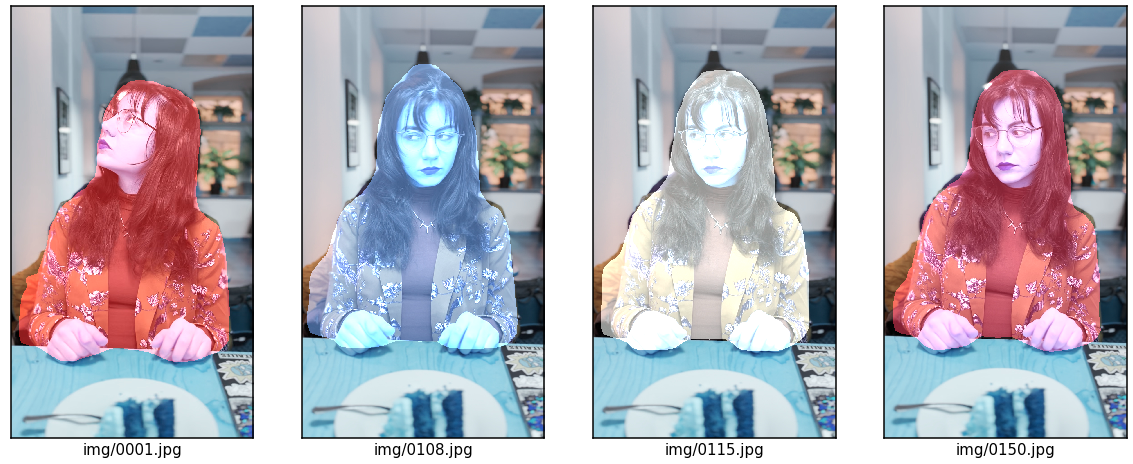

In [9]:
xlen = len(image_paths)
fig, axes = plt.subplots(1, xlen)
fig.set_size_inches(20,10)
for ax, img_path in zip(axes, image_paths):
    image = Image.open(img_path)
    # keep a copy of the original image for OpenCV functions and applying masks
    orig_image = image.copy()
    # transform the image
    image = transform(image)
    # add a batch dimension
    image = image.unsqueeze(0).to(device)
    masks, boxes, labels = get_outputs(image, model, threshold)
    output_img = draw_segmentation_map(orig_image, masks, boxes, labels)
    #gosh than feels ugly ^^
    isns.imgplot(output_img.astype('uint8'), ax=ax, cbar=False)
    ax.invert_yaxis()
    ax.set_xlabel(img_path)